In [1]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
#using our standard settings for our databse cs_mdfps
config = lwreg.utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'scotland'
config['user'] = 'cschiebroek'
config['password'] = '' 
config['standardization'] = standardization_lib.RemoveHs()
config['registerConformers'] = True

In [2]:
import pandas as pd
df_opera_naef_acree = pd.read_csv('OPERA_plus_Naef_Acree_incl_overlap_descriptors.csv')
#lets remove duplicates, keeping from OPERA
df_opera_naef_acree = df_opera_naef_acree.sort_values(by=['source'])
df_opera_naef_acree = df_opera_naef_acree.drop_duplicates(subset=['inchikey'],keep='last')
df_opera_naef_acree['source'].value_counts()

source
OPERA         2353
Naef_Acree    1069
Name: count, dtype: int64

In [110]:
smiles = df_opera_naef_acree['standardized_smiles'].tolist()
sources = df_opera_naef_acree['source'].tolist()
vp_vals = df_opera_naef_acree['log10_VP_Pa'].tolist()

In [112]:
from rdkit.Chem import rdmolops
from rdkit.Chem import AllChem
from rdkit import Chem

mols_3d = []
for smi,source,vp in zip(smiles,sources,vp_vals):
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=True))
    except:
        print('failed for: ',smi)
        break
    AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("used_smiles", used_smiles)
    mol.SetProp("Source", source)
    mol.SetProp("VP_log10_Pa", str(vp))
    mol.UpdatePropertyCache(strict=False)
    mols_3d.append(mol)

[13:12:41] UFFTYPER: Unrecognized atom type: S_6+6 (6)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (5)
[13:12:49] UFFTYPER: Unrecognized atom type: S_5+4 (7)
[13:12:49] UFFTYPER: Unrecognized atom type: S_5+4 (4)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (6)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (17)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (4)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (11)
[13:12:49] UFFTYPER: Unrecognized atom type: S_5+4 (7)
[13:12:49] UFFTYPER: Unrecognized atom type: S_5+4 (10)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (3)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (11)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[13:12:49] UFFTYPER: Unrecognized atom type: S_5+4 (5)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (1)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (7)
[13:12:49] UFFTYPER: Unrecognized atom type: S_6+6 (13)
[13:12:50] UFFTYPER: Unrecognized atom type: S_6+6 (6)
[13:1

In [52]:
#query these mols
not_found_counter = 0
not_found_mols = []
failed_mols = []
for m in mols_3d:
    query = lwreg.query(config = config, mol=m)
    if len(query) == 0:
        not_found_counter += 1
        not_found_mols.append(m)
        #try to registser
        try:
            lwreg.register(config = config, mol=m)
        except:
            print('failed to register: ',Chem.MolToSmiles(m))
            failed_mols.append(m)
    else:
        continue

failed to register:  [H]C1([H])[C@@]2([H])[C@]3([H])O[C@]3([H])[C@]1([H])[C@@]1([H])[C@@]2([H])[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
failed to register:  [H]C([H])([H])[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]


note the different between smiles and mols recognized: this is because stereo is not specified in the smiles, but it is for for the mols (assigned after conformer generation)

try to register these two again

In [12]:
lwreg.register(config=config,mol=failed_mols[0])

ValueError: attempt to register a molecule without conformers when registerConformers is set

In [54]:
for m in failed_mols:
    print(m.GetNumConformers())

0
0


so confgen failed for these

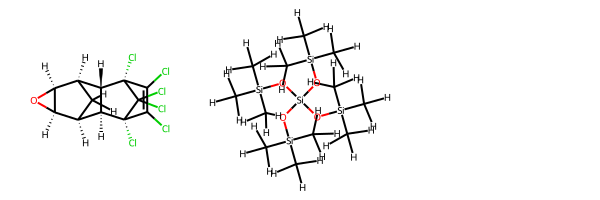

In [13]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(failed_mols)

lets drop these, or we would have to do it again but with using random coordinates

What do we have to do now?
1. Add to confid data
2. Add to confid_metadata (santize = True)
3. Change name experimental data table to something descriptive
4. Create new experimental data table
5. Fill new experimental data table with new data (think about metadata, just source? for OPERA mols we could add all info as json)

In [16]:
import uuid
confgen_uuid = str(uuid.uuid4())
print(confgen_uuid)

2153b1f8-cb83-4974-86a3-249f49ab55b7


In [34]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()

In [39]:
cur.execute("SELECT conf_id FROM cs_mdfps_schema.confid_data")
conf_ids_with_confgen_data = cur.fetchall()


In [40]:
print(len(conf_ids_with_confgen_data))

14197


In [41]:
#now get all conf_id from confors table
cur.execute("SELECT conf_id FROM conformers")
all_conf_ids = cur.fetchall()
print(len(all_conf_ids))

15495


In [ ]:
#get the difference
all_conf_ids = [x[0] for x in all_conf_ids]
conf_ids_with_confgen_data = [x[0] for x in conf_ids_with_confgen_data]

In [46]:
conf_ids_to_record = list(set(all_conf_ids) - set(conf_ids_with_confgen_data))
print(len(conf_ids_to_record))

1298


In [32]:
new_confids = []
for m in mols_3d:
    query = lwreg.query(config = config, mol=m)
    if len(query) == 0:
        print('not found in database: ',Chem.MolToSmiles(m))
    else:
        confid = query[0][1]
        new_confids.append(confid)

not found in database:  [H]C1([H])[C@@]2([H])[C@]3([H])O[C@]3([H])[C@]1([H])[C@@]1([H])[C@@]2([H])[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
not found in database:  [H]C([H])([H])[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]


In [33]:
print(len(new_confids))

403


In [47]:
#get all molregnos from cs_mdfps_schema.experimental_data
cur.execute("SELECT molregno FROM cs_mdfps_schema.experimental_data")
molregnos_shuzhe = cur.fetchall()
print(len(molregnos_shuzhe))
molregnos_shuzhe

3027


[(1,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,),
 (21,),
 (22,),
 (23,),
 (24,),
 (25,),
 (26,),
 (27,),
 (28,),
 (29,),
 (30,),
 (31,),
 (32,),
 (33,),
 (34,),
 (35,),
 (36,),
 (37,),
 (38,),
 (39,),
 (40,),
 (41,),
 (42,),
 (43,),
 (44,),
 (45,),
 (46,),
 (47,),
 (48,),
 (49,),
 (50,),
 (51,),
 (52,),
 (53,),
 (54,),
 (55,),
 (56,),
 (57,),
 (58,),
 (59,),
 (60,),
 (61,),
 (62,),
 (63,),
 (64,),
 (65,),
 (66,),
 (67,),
 (68,),
 (69,),
 (70,),
 (71,),
 (72,),
 (73,),
 (74,),
 (75,),
 (76,),
 (77,),
 (78,),
 (79,),
 (80,),
 (81,),
 (82,),
 (83,),
 (85,),
 (86,),
 (87,),
 (88,),
 (89,),
 (90,),
 (91,),
 (92,),
 (93,),
 (94,),
 (95,),
 (96,),
 (97,),
 (98,),
 (99,),
 (100,),
 (101,),
 (102,),
 (103,),
 (104,),
 (105,),
 (106,),
 (107,),
 (108,),
 (109,),
 (110,),
 (111,),
 (112,),
 (113,),
 (114,),
 (115,),
 (116,),
 (117,),
 (118,),
 (119,),
 (120,),
 (121,),
 (122,),
 (123,),
 (124,),
 (125,),
 (126,),
 (127,),
 

In [57]:
molregnos_shuzhe = [x[0] for x in molregnos_shuzhe]
molregnos_shuzhe

[1,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 

In [56]:
#query the new mols, if molregno not in here, then we need to keep it, get the conf_id for that molregno, and record it
print(len(mols_3d))
new_molregnos = []
for m in mols_3d:
    query = lwreg.query(config = config, mol=m)
    if len(query) == 0:
        print('not found in database: ',Chem.MolToSmiles(m))
    else:
        molregno = query[0][0]
        new_molregnos.append(molregno)
print(len(new_molregnos))
print(new_molregnos)

3422
not found in database:  [H]C1([H])[C@@]2([H])[C@]3([H])O[C@]3([H])[C@]1([H])[C@@]1([H])[C@@]2([H])[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
not found in database:  [H]C([H])([H])[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
3420
[15666, 1001, 15667, 15668, 15669, 3432, 3923, 15670, 15671, 518, 3174, 3725, 525, 692, 460, 3563, 2600, 754, 15672, 3930, 3085, 2410, 15673, 15674, 2465, 233, 15675, 4237, 2862, 3119, 2516, 2651, 2838, 15676, 135, 623, 3005, 15677, 2921, 15678, 390, 2885, 244, 15679, 3332, 15680, 4092, 1053, 15681, 3607, 3469, 15682, 3370, 2687, 3063, 15683, 2415, 3177, 4127, 4179, 1041, 15684, 15685, 412, 15686, 951, 15687, 15688, 15689, 3801, 15690, 2268, 757, 15691, 15692, 15693, 3505, 4159, 550, 400, 15694, 198, 286, 4180, 15695, 346, 843, 3395, 806, 3615, 15696, 3634, 2601, 2625, 2884, 4240, 3374, 3182, 212, 15697, 2257

In [58]:
not_overlapping_molregnos = [m for m in new_molregnos if m not in molregnos_shuzhe]
print(len(not_overlapping_molregnos))
not_overlapping_molregnos

1240


[15666,
 15667,
 15668,
 15669,
 15670,
 15671,
 15672,
 15673,
 15674,
 15675,
 15676,
 15677,
 15678,
 15679,
 15680,
 15681,
 15682,
 15683,
 15684,
 15685,
 15686,
 15687,
 15688,
 15689,
 15690,
 15691,
 15692,
 15693,
 15694,
 15695,
 15696,
 15697,
 15698,
 15699,
 15700,
 15701,
 15702,
 15703,
 15704,
 15705,
 15706,
 15707,
 15708,
 15709,
 15710,
 15711,
 15712,
 15713,
 15714,
 15715,
 15716,
 15717,
 15718,
 15719,
 15720,
 15721,
 15722,
 15723,
 15724,
 15725,
 15726,
 15727,
 15728,
 15729,
 15730,
 15731,
 15732,
 15733,
 15734,
 15735,
 15736,
 15737,
 15738,
 15739,
 15740,
 15741,
 15742,
 15743,
 15744,
 15745,
 15746,
 15747,
 15748,
 15749,
 15750,
 15751,
 15752,
 15753,
 15754,
 15755,
 15756,
 15757,
 15758,
 15759,
 15760,
 15761,
 15762,
 15763,
 15764,
 15765,
 15766,
 15767,
 15768,
 15769,
 15770,
 15771,
 15772,
 15773,
 15774,
 15775,
 15776,
 15777,
 15778,
 15779,
 15780,
 15781,
 15782,
 15783,
 15784,
 15785,
 15786,
 15787,
 15788,
 15789,
 15790,


In [59]:
#check if for the other, you already have mdfps; 
overlapping_molregnos = [m for m in new_molregnos if m in molregnos_shuzhe]
#for these, get the conf_ids, and check if there is an entry for this conf_id in cs_mdfps_schema.mdfp_experiment_data, using an sql query
#get the conf_ids for these molregnos that have an entry in cs_mdfps_schema.mdfp_experiment_data in one sql query


UndefinedColumn: column "conf_id" does not exist
LINE 1: SELECT conf_id FROM cs_mdfps_schema.experimental_data WHERE ...
               ^


In [77]:
cn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = cn.cursor()

In [62]:
cur.execute("""SELECT DISTINCT c.molregno
FROM conformers c
WHERE NOT EXISTS (
    SELECT 1
    FROM cs_mdfps_schema.mdfp_experiment_data e
    WHERE e.conf_id = c.conf_id
);""")
molregnos_no_mdfp = cur.fetchall()

print(len(molregnos_no_mdfp))
molregnos_no_mdfp

1521


[(4201,),
 (16592,),
 (16204,),
 (16806,),
 (3309,),
 (273,),
 (17028,),
 (3612,),
 (15685,),
 (16699,),
 (16859,),
 (4008,),
 (16105,),
 (2520,),
 (16379,),
 (15820,),
 (2331,),
 (16197,),
 (16143,),
 (15745,),
 (16354,),
 (16147,),
 (1003,),
 (16116,),
 (292,),
 (15687,),
 (16313,),
 (16070,),
 (15995,),
 (16152,),
 (2740,),
 (16863,),
 (16072,),
 (16228,),
 (15682,),
 (16368,),
 (16762,),
 (16288,),
 (16054,),
 (2749,),
 (16326,),
 (15863,),
 (15814,),
 (15805,),
 (16809,),
 (15904,),
 (16043,),
 (17135,),
 (16473,),
 (16447,),
 (16106,),
 (16322,),
 (3211,),
 (16383,),
 (15849,),
 (16478,),
 (632,),
 (16046,),
 (16598,),
 (4095,),
 (15909,),
 (15876,),
 (15732,),
 (15703,),
 (16579,),
 (16717,),
 (16432,),
 (16211,),
 (15940,),
 (15779,),
 (3700,),
 (16363,),
 (824,),
 (15899,),
 (16730,),
 (15910,),
 (2366,),
 (769,),
 (17105,),
 (16314,),
 (15979,),
 (15872,),
 (17025,),
 (2553,),
 (16822,),
 (16047,),
 (15833,),
 (3749,),
 (16477,),
 (15945,),
 (15851,),
 (17119,),
 (16827,),
 (

In [63]:
molregnos_no_mdfp = [m[0] for m in molregnos_no_mdfp]
molregnos_no_mdfp

[4201,
 16592,
 16204,
 16806,
 3309,
 273,
 17028,
 3612,
 15685,
 16699,
 16859,
 4008,
 16105,
 2520,
 16379,
 15820,
 2331,
 16197,
 16143,
 15745,
 16354,
 16147,
 1003,
 16116,
 292,
 15687,
 16313,
 16070,
 15995,
 16152,
 2740,
 16863,
 16072,
 16228,
 15682,
 16368,
 16762,
 16288,
 16054,
 2749,
 16326,
 15863,
 15814,
 15805,
 16809,
 15904,
 16043,
 17135,
 16473,
 16447,
 16106,
 16322,
 3211,
 16383,
 15849,
 16478,
 632,
 16046,
 16598,
 4095,
 15909,
 15876,
 15732,
 15703,
 16579,
 16717,
 16432,
 16211,
 15940,
 15779,
 3700,
 16363,
 824,
 15899,
 16730,
 15910,
 2366,
 769,
 17105,
 16314,
 15979,
 15872,
 17025,
 2553,
 16822,
 16047,
 15833,
 3749,
 16477,
 15945,
 15851,
 17119,
 16827,
 16901,
 16315,
 4022,
 16135,
 181,
 16746,
 16173,
 743,
 15877,
 15867,
 16883,
 16950,
 16600,
 16226,
 16027,
 17104,
 16243,
 15800,
 16419,
 15825,
 15677,
 13691,
 963,
 16511,
 3952,
 16371,
 16462,
 16819,
 16839,
 175,
 16912,
 285,
 16005,
 15823,
 16938,
 15803,
 3301

In [64]:
molregnos_to_simulate = [m for m in new_molregnos if m in molregnos_no_mdfp]
print(len(molregnos_to_simulate))

1496


In [68]:
#but this was a bit of a side-track; we want to get the conf-ids of the newely simulated mols. so lets first get all the conf_ids
confids_new_dataset = []
for m in mols_3d:
    query = lwreg.query(config = config, mol=m)
    if len(query) == 0:
        print('not found in database: ',Chem.MolToSmiles(m))
    else:
        confid = query[0][1]
        confids_new_dataset.append(confid)

not found in database:  [H]C1([H])[C@@]2([H])[C@]3([H])O[C@]3([H])[C@]1([H])[C@@]1([H])[C@@]2([H])[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
not found in database:  [H]C([H])([H])[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]


In [78]:
# Prepare a parameterized query dynamically
query = """
    SELECT conf_id
    FROM cs_mdfps_schema.confid_data
    WHERE conf_id = ANY(%s);
"""

# Execute the query with the list of confids as a parameter
cur.execute(query, (confids_new_dataset,))

# Fetch the results
existing_confids = cur.fetchall()

# Find the confids that are not in the cs_mdfp_schema.confid_data table
new_confids = set(confids_new_dataset) - set(existing_confids)

# Print the results
print(len(new_confids))

3419
[16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16408, 16410, 16411, 16416, 16417, 16418, 16420, 16421, 16424, 16426, 16430, 16431, 16432, 16441, 16445, 16446, 16450, 16451, 16452, 16454, 16455, 16458, 16460, 16461, 16464, 16465, 16466, 16467, 16468, 16469, 16471, 16472, 16473, 16475, 16476, 16477, 16478, 16480, 16483, 16485, 16487, 16489, 16490, 16491, 16492, 16496, 16497, 16498, 16499, 16503, 16505, 16509, 16518, 16520, 16521, 16522, 16523, 16525, 16545, 16549, 16552, 16558, 16559, 16560, 16561, 16564, 16566, 16569, 16570, 16573, 16575, 16577, 16578, 16579, 16580, 16581, 16582, 16583, 16586, 16587, 16588, 16589, 16590, 16592, 16593, 16594, 16595, 16596, 16597, 16598, 16600, 16603, 16604, 16605, 16611, 16612, 16617, 16618, 16619, 16621, 16622, 16623, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16636, 16637, 16638, 16639, 16641, 16642, 16643, 16645, 16646, 16647, 16648, 

In [81]:
existing_confids = [x[0] for x in existing_confids]
# Find the confids that are not in the cs_mdfp_schema.confid_data table
new_confids = set(confids_new_dataset) - set(existing_confids)
# Print the results
print(len(new_confids))

1345


In [82]:
#store in the database: these confids with the confgen_uuid
for confid in new_confids:
    cur.execute("INSERT INTO cs_mdfps_schema.confid_data (conf_id, confgen_uuid) VALUES (%s, %s)", (confid, confgen_uuid))

In [83]:
#commit
cn.commit()


In [84]:
#now, get for each conf_id in confids_new_dataset, the confgen_uuid
query = """
    SELECT conf_id, confgen_uuid
    FROM cs_mdfps_schema.confid_data
    WHERE conf_id = ANY(%s);
"""

# Execute the query with the list of confids as a parameter
cur.execute(query, (confids_new_dataset,))
result = cur.fetchall()
result

[(1151, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (2388, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (2415, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1156, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1157, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1164, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1165, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1167, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1168, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1161, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1162, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1169, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1166, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1175, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1171, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1163, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1177, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1178, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1179, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1188, '906589dd-76fa-4d7b-aa9f-1ee90abe3835'),
 (1187, '906589dd-76

In [87]:
confids = [x[0] for x in result]
confgen_uuids = [x[1] for x in result]
#count values of confgen_uuids
from collections import Counter
Counter(confgen_uuids)

Counter({'906589dd-76fa-4d7b-aa9f-1ee90abe3835': 2074,
         '2153b1f8-cb83-4974-86a3-249f49ab55b7': 1345})

In [88]:
#then register the conf gen metadata
import json
import psycopg2
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
params = {"randomSeed": 0xf00d, "enforceChirality": True, "MMFF_minimization": False, "Sanitze_mols":True}
params_json = json.dumps(params)
cur.execute('insert into cs_mdfps_schema.confid_metadata values (%s,%s)',(str(confgen_uuid),str(params_json)))
cn.commit()

In [89]:
#now change the name of table cs_mdfp_schema.experimental_data to cs_mdfp_schema.experimental_data_Shuzhe
cur.execute('ALTER TABLE cs_mdfps_schema.experimental_data RENAME TO experimental_data_shuzhe')
cn.commit()

now we have to create a new table cs_mdfp_schema.experimental_data_opera_naef_acree. but first, we have to think about the columns. I would say: molregno (primary key), VP (log10 Pa), Source, metadata. In metadata, we can just put a json of all the properties in the sdf, this will be different for the different sources

In [125]:
#create table
cur.execute('create table cs_mdfps_schema.experimental_data(molregno int primary key, VP_log10_Pa double precision, source text,metadata jsonb)')
cn.commit()


DuplicateTable: relation "experimental_data" already exists


In [127]:
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()

In [129]:
#now lets populate this table: we go over mols_3d, get the molregno from query, the vp and source from mol property
for m in mols_3d:
    query = lwreg.query(config = config, mol=m)
    if len(query) == 0:
        print('not found in database: ',Chem.MolToSmiles(m))
    else:
        molregno = query[0][0]
        vp = m.GetProp("VP_log10_Pa")
        source = m.GetProp("Source")
        metadata = {}
        metadata_json = json.dumps(metadata)
        #check if this molregno is already in the database
        cur.execute('select * from cs_mdfps_schema.experimental_data where molregno = %s',(molregno,))
        result = cur.fetchall()
        if len(result) > 0:
            #check if the vp already registered is the same as vp
            if result[0][1] != vp:
                print('molregno already in database: ',molregno)
                print('Data recorded: ')
                print(result)
                print('New data: ')
                print(molregno,vp,source,metadata_json)
                #if the source recorded is Naef_Acree, then we update the vp
                if result[0][2] == 'Naef_Acree':
                    cur.execute('update cs_mdfps_schema.experimental_data set VP_log10_Pa = %s where molregno = %s',(vp,molregno))
                else:
                    print('source is not Naef_Acree, so we will not update the vp')
                #this way we consitantly keep vp from OPERA, and only update if the source is Naef_Acree
        else:
            cur.execute('insert into cs_mdfps_schema.experimental_data values (%s,%s,%s,%s)',(molregno,vp,source,metadata_json))


not found in database:  [H]C1([H])[C@@]2([H])[C@]3([H])O[C@]3([H])[C@]1([H])[C@@]1([H])[C@@]2([H])[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
molregno already in database:  2417
Data recorded: 
[(2417, -1.699, 'Naef_Acree', {})]
New data: 
2417 -1.6989982351331776 OPERA {}
molregno already in database:  3253
Data recorded: 
[(3253, 4.37, 'Naef_Acree', {})]
New data: 
3253 4.3746014675202485 OPERA {}
molregno already in database:  2307
Data recorded: 
[(2307, 3.51, 'Naef_Acree', {})]
New data: 
2307 3.512302325588294 OPERA {}
molregno already in database:  16086
Data recorded: 
[(16086, 3.726, 'Naef_Acree', {})]
New data: 
16086 3.171002701710921 OPERA {}
molregno already in database:  848
Data recorded: 
[(848, 5.616, 'Naef_Acree', {})]
New data: 
848 5.585502016475062 OPERA {}
not found in database:  [H]C([H])([H])[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H

In [131]:
#get all sources, and count them
cur.execute('select source, count(*) from cs_mdfps_schema.experimental_data group by source')
result = cur.fetchall()
result

[('Naef_Acree', 1068), ('OPERA', 2288)]

In [132]:
cn.commit()

In [134]:
#now lets check if it is all correct: query the database for all mols, and check if the vp is correct
for m in mols_3d:
    query = lwreg.query(config = config, mol=m)
    if len(query) == 0:
        print('not found in database: ',Chem.MolToSmiles(m))
    else:
        molregno = query[0][0]
        vp = m.GetProp("VP_log10_Pa")

        #get registered vp for this molecule by querying the database 
        cur.execute('select VP_log10_Pa from cs_mdfps_schema.experimental_data where molregno = %s',(molregno,))
        result = cur.fetchall()
        if len(result) == 0:
            print('no vp registered for molregno: ',molregno)
        else:
            if float(result[0][0]) != float(vp):
                print('vp not equal for molregno: ',molregno)
                print('registered vp: ',result[0][0])
                print('vp from mol: ',vp)



vp not equal for molregno:  3332
registered vp:  -3.346198183669136
vp from mol:  -2.86
vp not equal for molregno:  3801
registered vp:  -2.9999981213590505
vp from mol:  -3.0
vp not equal for molregno:  3395
registered vp:  -3.460098107028849
vp from mol:  -3.456
vp not equal for molregno:  3897
registered vp:  -5.6989982351331765
vp from mol:  -4.222
vp not equal for molregno:  15720
registered vp:  -3.644697800121065
vp from mol:  -3.646
vp not equal for molregno:  2905
registered vp:  -2.378898039788176
vp from mol:  -2.377
vp not equal for molregno:  3309
registered vp:  -2.3347987438982702
vp from mol:  -2.337
not found in database:  [H]C1([H])[C@@]2([H])[C@]3([H])O[C@]3([H])[C@]1([H])[C@@]1([H])[C@@]2([H])[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
vp not equal for molregno:  2417
registered vp:  -1.6989982351331776
vp from mol:  -1.699
vp not equal for molregno:  2753
registered vp:  -5.53659786071489
vp from mol:  -5.509
vp not equal for molregno:  602
registered vp:  3.33820171106

Additionally, we could make a property table per molregno with the PhysChem properties, would be even faster and prevent recalculation. But this we can do later.

In [137]:
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()

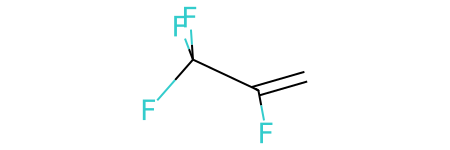

In [143]:
cur.execute('select * from conformers where molregno = %s',(molregnos_to_simulate[0],))
result = cur.fetchall()
result
mol = Chem.MolFromMolBlock(result[0][-1])
mol

In [145]:
#get all molblocks for the molregnos_to_simulate
query = """
    SELECT molregno, molblock
    FROM conformers
    WHERE molregno = ANY(%s);
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query, (molregnos_to_simulate,))
result = cur.fetchall()
print(len(result))
print(result[0])

2280
(2390, '[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 10 10 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 3.504903 0.510746 0.342615 0\nM  V30 2 C 2.305884 -0.017947 0.313519 0\nM  V30 3 C 1.386762 0.217584 1.405386 0\nM  V30 4 C 0.093030 0.307013 1.115199 0\nM  V30 5 C -0.280772 0.156627 -0.302815 0 CFG=2\nM  V30 6 C -1.757313 0.178518 -0.497845 0\nM  V30 7 C -2.426833 -0.952773 0.272219 0\nM  V30 8 C -2.284437 1.506201 -0.002609 0\nM  V30 9 C 0.407432 -1.019146 -0.953583 0\nM  V30 10 C 1.882801 -0.862709 -0.821664 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 2 3 4\nM  V30 4 1 4 5\nM  V30 5 1 5 6 CFG=1\nM  V30 6 1 6 7\nM  V30 7 1 6 8\nM  V30 8 1 5 9\nM  V30 9 1 9 10\nM  V30 10 1 10 2\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n')


In [148]:
molregnos = [x[0] for x in result]
#get duplicate molregnos
from collections import Counter
molregno_counter = Counter(molregnos)
duplicates = [k for k,v in molregno_counter.items() if v > 1]
print(len(duplicates))
duplicates[0]

200


2390

In [153]:
#query this molregno in lwreg: 2390
lwreg.query(config = config, ids=[2390,])

[(2390, 2388),
 (2390, 8193),
 (2390, 8194),
 (2390, 8195),
 (2390, 8196),
 (2390, 8197),
 (2390, 17258)]

In [155]:
#okay, interesting; so we do also have molregnos, for which we did already generate conformers, but for which we did not obtain mdfps? lets check: get the conf_ids from this query, and check if there are entries for these in cs_mdfps_schema.mdfp_experiment_data
query = lwreg.query(config = config, ids=[2390,])
conf_ids = [x[1] for x in query]
print(conf_ids)
#search for these conf_ids in cs_mdfps_schema.mdfp_experiment_data
# okay, interesting; so we do also have molregnos, for which we did already generate conformers, but for which we did not obtain mdfps? let's check: get the conf_ids from this query, and check if there are entries for these in cs_mdfps_schema.mdfp_experiment_data
query = lwreg.query(config=config, ids=[2390])
conf_ids = [x[1] for x in query]
print(conf_ids)
# search for these conf_ids in cs_mdfps_schema.mdfp_experiment_data
cur.execute('SELECT * FROM cs_mdfps_schema.mdfp_experiment_data WHERE conf_id IN %s', (tuple(conf_ids),))
result = cur.fetchall()
result


[2388, 8193, 8194, 8195, 8196, 8197, 17258]
[2388, 8193, 8194, 8195, 8196, 8197, 17258]


[(2388,
  'fc57851e-b654-4338-bcdd-faa28ec66253',
  {'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540933, 0.39851061882941313, -24.348582835667543, 29.773114168892423, 5.2661979615540035, 29.414383098454888, -36.19785832644828, 6.9291222715587715, -36.0114195778666, -35.96362442571197, 7.861005156060701, -37.1019174745538, 5.409350714799121, 5.120615277516713, 5.08136845690877, -72.16148275216024, 10.52991145898909, -72.40260282291774, 0.2392068971839293, 0.0018383800165236905, 0.23927469491821807, 3.536894, 0.017106198, 3.5361013]'},
  '11e1a9f9-393b-4056-852f-d06cf145bd15',
  'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (8196,
  'e0f120fb-efa9-4c88-a964-e7b99253027c',
  {'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -23.461133152595732, 0.3622401083867726, -23.47609039135885, 26.628847080287816, 5.319013951661441, 25.912027797939757, -35.05884680210684, 6.673194639619137, -34.45345916392324, -37.09243241217874, 7.8474534870552795, -37.21427588700176, 3.1677139276920863, 5.221290918955

In [156]:
#okay, I guess we have to do it different, do a query where we get: molregno and vapor pressure from cs_mdfps_schema.experimental_data, and conf_id from conformers, and mdfp from mdfp_experiment_data
query = """
    SELECT e.molregno, e.VP_log10_Pa, c.conf_id, m.mdfp
    FROM cs_mdfps_schema.experimental_data e
    JOIN conformers c ON e.molregno = c.molregno
    JOIN cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query)
result = cur.fetchall()
print(len(result))

11653


In [159]:
result
#get molregnos
molregnos_with_mdfp = [x[0] for x in result]
molregnos_with_mdfp
#now get all molregnos that are in cs_mdfps_schema.experimental_data but not in molregnos_with_mdfp
cur.execute('SELECT molregno FROM cs_mdfps_schema.experimental_data')
all_molregnos = cur.fetchall()
all_molregnos = [x[0] for x in all_molregnos]
print(len(all_molregnos))
print(len(molregnos_with_mdfp))
not_in_mdfp = [m for m in all_molregnos if m not in molregnos_with_mdfp]
print(len(not_in_mdfp))
not_in_mdfp

3356
11653
1248


[15666,
 15667,
 15668,
 15669,
 15670,
 15671,
 15672,
 15673,
 15674,
 15675,
 15676,
 15677,
 15678,
 15679,
 15680,
 15681,
 15682,
 15683,
 15684,
 15685,
 15686,
 15687,
 15688,
 15689,
 15690,
 15691,
 15692,
 15693,
 15694,
 15695,
 15696,
 15697,
 15698,
 15699,
 15700,
 15701,
 15702,
 15703,
 15704,
 15705,
 15706,
 15707,
 15708,
 15709,
 15710,
 15711,
 15712,
 15713,
 15714,
 15715,
 15716,
 15717,
 15718,
 15719,
 15721,
 15722,
 15723,
 15724,
 15725,
 15726,
 15727,
 15728,
 15729,
 15730,
 15731,
 15732,
 15733,
 15734,
 15735,
 15736,
 15737,
 15738,
 15739,
 15740,
 15741,
 15742,
 15743,
 15744,
 15745,
 15746,
 15747,
 15748,
 15749,
 15750,
 15751,
 15752,
 15753,
 15754,
 15755,
 15756,
 15757,
 15758,
 15759,
 15760,
 15761,
 15762,
 15763,
 15764,
 15765,
 15766,
 15767,
 15768,
 15769,
 15770,
 15771,
 15772,
 15773,
 15774,
 15775,
 15776,
 15777,
 15778,
 15779,
 15780,
 15781,
 15782,
 15783,
 15784,
 15785,
 15786,
 15787,
 15788,
 15789,
 15790,
 15791,


In [160]:
#for these, get the confids
query = """
    SELECT c.conf_id
    FROM cs_mdfps_schema.experimental_data e
    JOIN conformers c ON e.molregno = c.molregno
    WHERE e.molregno = ANY(%s)
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query, (not_in_mdfp,))
result = cur.fetchall()
print(len(result))
result

1263


[(2453,),
 (2405,),
 (1205,),
 (3155,),
 (1220,),
 (1239,),
 (1382,),
 (1860,),
 (1890,),
 (1891,),
 (2058,),
 (2373,),
 (2527,),
 (2879,),
 (2877,),
 (2924,),
 (4063,),
 (3530,),
 (3547,),
 (4107,),
 (4137,),
 (4170,),
 (15882,),
 (16063,),
 (16801,),
 (16852,),
 (16855,),
 (16856,),
 (16857,),
 (16858,),
 (17135,),
 (17148,),
 (15961,),
 (16071,),
 (16080,),
 (15664,),
 (15665,),
 (15666,),
 (16090,),
 (15667,),
 (15668,),
 (15669,),
 (15670,),
 (15671,),
 (15962,),
 (15672,),
 (15673,),
 (15674,),
 (15675,),
 (15811,),
 (15676,),
 (15677,),
 (15678,),
 (15679,),
 (15680,),
 (15681,),
 (15682,),
 (15683,),
 (15684,),
 (15685,),
 (15812,),
 (15686,),
 (15687,),
 (15688,),
 (15689,),
 (15690,),
 (15705,),
 (15691,),
 (15692,),
 (15693,),
 (15694,),
 (15719,),
 (15695,),
 (15696,),
 (15697,),
 (15698,),
 (15699,),
 (15700,),
 (15701,),
 (15702,),
 (15703,),
 (15704,),
 (15706,),
 (15707,),
 (15708,),
 (15709,),
 (15813,),
 (15710,),
 (15711,),
 (15712,),
 (15713,),
 (15720,),
 (15714,),

In [170]:
#get all molregnos from not_in_mdfp that have more then 1 conf_id
from collections import Counter
query = """
    SELECT c.molregno, count(c.conf_id)
    FROM cs_mdfps_schema.experimental_data e
    JOIN conformers c ON e.molregno = c.molregno
    WHERE e.molregno = ANY(%s)
    GROUP BY c.molregno
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query, (not_in_mdfp,))
result = cur.fetchall()
#get the ones with more then 1 conf_id
result = [x for x in result if x[1] > 1]
print(len(result))
result



15


[(16288, 2),
 (15720, 2),
 (16035, 2),
 (2375, 2),
 (3461, 2),
 (16173, 2),
 (15897, 2),
 (16375, 2),
 (16039, 2),
 (16010, 2),
 (16204, 2),
 (16368, 2),
 (16314, 2),
 (16086, 2),
 (464, 2)]

In [171]:
molregnos_to_check = [x[0] for x in result]
molregnos_to_check

[16288,
 15720,
 16035,
 2375,
 3461,
 16173,
 15897,
 16375,
 16039,
 16010,
 16204,
 16368,
 16314,
 16086,
 464]

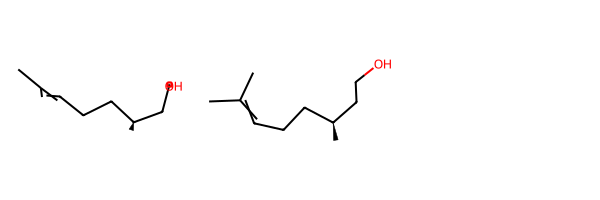

In [168]:
query = lwreg.retrieve(config = config, ids=[(16288, 16286), (16288, 16712)])
mols = [Chem.MolFromMolBlock(x[-1]) for x in query]
Draw.MolsToGridImage(mols)

In [172]:
#okay for these molregnos, get the conf_ids, and check if they have the same confgen_uuid
query = """
    SELECT c.molregno, c.conf_id, m.confgen_uuid
    FROM cs_mdfps_schema.experimental_data e
    JOIN conformers c ON e.molregno = c.molregno
    JOIN cs_mdfps_schema.confid_data m ON c.conf_id = m.conf_id
    WHERE e.molregno = ANY(%s)
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query, (molregnos_to_check,))
result = cur.fetchall()
result

[(2375, 2373, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (15720, 15718, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (15897, 15895, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16010, 16008, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16035, 16033, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16039, 16037, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16086, 16084, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16173, 16171, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16204, 16202, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16288, 16286, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16314, 16312, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16375, 16373, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16368, 16366, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16086, 16432, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (15720, 16583, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16288, 16712, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16173, 16723, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16368, 16769, '2153b1f8-cb83-49

how can that be? must be because it is the same mol in both databases, but with different specifications of the stereo.

In [179]:
#As we have decided to first keep values from OPERA, which were first in the DF, lets, for this set of mols, drop the higher conf_id from conformers and from cs_mdfp
#first, get the conf_ids that are higher
result
molregnos_with_dups = [x[0] for x in result]
confids_dupped_molregnos = [x[1] for x in result]
#for each molregno, get the conf_id that is higher
highest_confids = []
confids_to_drop = []
for molregno in list(set(molregnos_with_dups)):
    confids = [x[1] for x in result if x[0] == molregno]
    highest_confids.append(max(confids))
    confids_to_drop.append(min(confids))
    print(molregno,max(confids),min(confids))

#now drop these conf_ids from conformers
query = """
    DELETE FROM conformers
    WHERE conf_id = ANY(%s)
"""

# Execute the query with the list of confids as a parameter
cur.execute(query, (confids_to_drop,))
cn.commit()

#now drop these conf_ids from confid_data
query = """
    DELETE FROM cs_mdfps_schema.confid_data
    WHERE conf_id = ANY(%s)
"""

# Execute the query with the list of confids as a parameter
cur.execute(query, (confids_to_drop,))
cn.commit()




16288 16712 16286
16035 16810 16033
3461 17211 17141
2375 17221 2373
15720 16583 15718
16039 16970 16037
16010 17020 16008
16204 16853 16202
16173 16723 16171
16368 16769 16366
464 17265 16797
16086 16432 16084
16375 17094 16373
15897 17034 15895
16314 17086 16312


In [180]:
#okay for these molregnos, get the conf_ids, and check if they have the same confgen_uuid
query = """
    SELECT c.molregno, c.conf_id, m.confgen_uuid
    FROM cs_mdfps_schema.experimental_data e
    JOIN conformers c ON e.molregno = c.molregno
    JOIN cs_mdfps_schema.confid_data m ON c.conf_id = m.conf_id
    WHERE e.molregno = ANY(%s)
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query, (molregnos_to_check,))
result = cur.fetchall()
result

[(16086, 16432, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (15720, 16583, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16288, 16712, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16173, 16723, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16368, 16769, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16035, 16810, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16204, 16853, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (2375, 17221, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16039, 16970, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16010, 17020, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (15897, 17034, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16314, 17086, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (16375, 17094, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (3461, 17211, '2153b1f8-cb83-4974-86a3-249f49ab55b7'),
 (464, 17265, '2153b1f8-cb83-4974-86a3-249f49ab55b7')]

In [185]:
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()

In [186]:
#for these, get the confids
query = """
    SELECT c.conf_id
    FROM cs_mdfps_schema.experimental_data e
    JOIN conformers c ON e.molregno = c.molregno
    WHERE e.molregno = ANY(%s)
"""

# Execute the query with the list of molregnos as a parameter
cur.execute(query, (not_in_mdfp,))
result = cur.fetchall()
print(len(result))
result

1248


[(2453,),
 (2405,),
 (1205,),
 (3155,),
 (1220,),
 (1239,),
 (1382,),
 (1860,),
 (1890,),
 (1891,),
 (2058,),
 (2527,),
 (2879,),
 (2877,),
 (2924,),
 (4063,),
 (3530,),
 (3547,),
 (4107,),
 (4137,),
 (4170,),
 (15882,),
 (16063,),
 (16801,),
 (16852,),
 (16855,),
 (16856,),
 (16857,),
 (16858,),
 (17135,),
 (17148,),
 (15961,),
 (16071,),
 (16080,),
 (15664,),
 (15665,),
 (15666,),
 (16090,),
 (15667,),
 (15668,),
 (15669,),
 (15670,),
 (15671,),
 (15962,),
 (15672,),
 (15673,),
 (15674,),
 (15675,),
 (15811,),
 (15676,),
 (15677,),
 (15678,),
 (15679,),
 (15680,),
 (15681,),
 (15682,),
 (15683,),
 (15684,),
 (15685,),
 (15812,),
 (15686,),
 (15687,),
 (15688,),
 (15689,),
 (15690,),
 (15705,),
 (15691,),
 (15692,),
 (15693,),
 (15694,),
 (15719,),
 (15695,),
 (15696,),
 (15697,),
 (15698,),
 (15699,),
 (15700,),
 (15701,),
 (15702,),
 (15703,),
 (15704,),
 (15706,),
 (15707,),
 (15708,),
 (15709,),
 (15813,),
 (15710,),
 (15711,),
 (15712,),
 (15713,),
 (15720,),
 (15714,),
 (15715,)

In [187]:
#good, for these conf_ids, get the molblocks and conf_ids
query = """
    SELECT molblock, conf_id
    FROM conformers
    WHERE conf_id = ANY(%s)
"""

# Execute the query with the list of confids as a parameter
cur.execute(query, (result,))
result = cur.fetchall()
print(len(result))



1248


In [189]:
#save these molblocks to a file, name is conf_id
for molblock,conf_id in result:
    with open('molblocks_opera_naef_acree/'+str(conf_id)+'.mol','w') as f:
        f.write(molblock)


In [190]:
#query mdfp for conf_id 1205
query = """
    SELECT mdfp
    FROM cs_mdfps_schema.mdfp_experiment_data
    WHERE conf_id = %s
"""

# Execute the query with the list of confids as a parameter
cur.execute(query, (1205,))
result = cur.fetchall()
result

[]

In [ ]:
#write a text file with the first 100 mdfps
with open('mdfps.txt','w') as f:
    for mdfp in result[:100]:
        f.write(mdfp[0]+'\n')